# Problem set 2 - Monte Carlo method & TD learning

**Due: 11:59pm, October 10, 2025**

### Problem 1 - Monte Carlo evaluation and Monte Carlo control (Coding).

TODO list:

- (1) Finish MC Policy Evaluation Code (10 pt)
- (2) Try different step size and discuss (10 pt)
- (3) Finish MC + Exploring Starts Code (10 pt)
- (4) Plot the convergence behavior, discuss the plot (10 pt)
- (5) Proof of Monte-Carlo control on *random walk* problem (20 pt)
- (6) Finish MC + epsilon greedy Code (10 pt)


<!-- - MC Policy Evaluation Code (long runtime)
- MC Policy Evaluation Different Step size plot
- MC + Exploring Starts Code (long run time)
- MC + ES Observe Plot, describe observation
- MC + ES proof 
- MC + epsilon greedy code  -->

### Problem 2 - Temporal-difference evaluation, SARSA and Q-learning
- (1) Finish TD evaluation Code (10 pt)
- (2) Finish SARSA algorithm (10 pt)
- (3) Finish Q-learning algorithm (10 pt)


<!-- - TD Evaluation
- SARSA
- Q-Learning -->


## Problem 1: Monte-Carlo method on CliffWalk environment.

Recall from last PSET, the **CliffWalking** gridworld is a 4×12 grid. The agent starts at the bottom-left cell and aims to reach the bottom-right. The bottom row between start and goal is a **cliff**; stepping into it ends the episode with a large penalty. Each non-terminal step yields −1; stepping into the cliff yields −100 (and termination).  

In this problem we will **directly use Gym/Gymnasium** to interact with the environment (`CliffWalking-v1`) and perform **Monte-Carlo (MC) method**. Here we provide the print utility function as the same in PSET 1.


In [1]:
import numpy as np
import random
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----- Reproducibility -----
seed = 0
np.random.seed(seed)          # numpy RNG (env seeding can be done at reset time)

# ----- Environment -----
env = gym.make("CliffWalking-v1")  # 4x12 grid; bottom row is cliff + goal

# Pretty printing for small numeric tables
np.set_printoptions(precision=3, suppress=True)

def print_values(values, nrow: int, ncol: int, title: str = "State Values"):
    """
    Print a value table V in grid form.
    """
    values = np.asarray(values).reshape(nrow, ncol)
    print(title)
    for r in range(nrow):
        print(" ".join(f"{values[r, c]:6.2f}" for c in range(ncol)))
    print()

def print_policy(pi, nrow: int, ncol: int, title: str = "Policy"):
    """
    Render a policy on the CliffWalking grid as arrows.

    The environment uses the action indexing:
        0 = UP, 1 = RIGHT, 2 = DOWN, 3 = LEFT
    """
    arrow = {0: "^", 1: ">", 2: "v", 3: "<"}  # matches env action semantics
    print(title)
    for i in range(nrow):
        row_syms = []
        for j in range(ncol):
            s = i * ncol + j
            p = pi[s]

            # Determine greedy action(s)
            if isinstance(p, list) and len(p) == 4:
                best = np.argwhere(np.array(p) == np.max(p)).flatten().tolist()
            elif isinstance(p, int):
                best = [p]
            else:
                arr = np.array(p, dtype=float).ravel()
                best = np.argwhere(arr == np.max(arr)).flatten().tolist()

            # Cliff/goal cells (bottom row except column 0) rendered as terminal
            if i == nrow - 1 and j > 0:
                row_syms.append("T")
            else:
                row_syms.append("".join(arrow[a] for a in best))
        print(" ".join(sym if sym else "." for sym in row_syms))
    print()

# ----- Reference table (ground-truth under random policy from PSET1) -----
# Shape is (4, 12) in row-major order, then flattened to 1D for convenience.
# Values correspond to the state-value function V^π for the UNIFORM RANDOM policy.
V_random_gt = np.array([
    [-143.21, -147.36, -151.35, -153.93, -155.11, -155.05, -153.66, -150.44, -144.43, -134.39, -119.88, -105.06],
    [-164.99, -174.34, -180.41, -183.52, -184.80, -184.82, -183.62, -180.68, -174.67, -162.95, -141.20, -108.16],
    [-207.96, -237.09, -246.20, -249.36, -250.43, -250.52, -249.79, -247.81, -243.17, -231.62, -199.35,  -96.76],
    [-261.35,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00],
], dtype=float).flatten()


### 1.1 Monte-Carlo evaluation

Let $\mathcal{D}(s)$ denote the set of all time indices at which state $s$ is visited across sampled episodes. Then the Monte Carlo estimate of the value function is
$$
\hat{V}(s)=\frac{1}{|\mathcal{D}(s)|}\sum_{t\in \mathcal{D}(s)} g_t .
\tag{2.3}
$$

There are two common variants:

- **First-visit MC:** use only the first occurrence of $s$ in each episode.
- **Every-visit MC:** use all occurrences of $s$ within an episode.

You can test both of them in 1.2. For 1.1 you need to finish the **first-visit** one.

**TODO: Finish the code block for monte-carlo evaluation.**


MC first-visit: 100%|██████████| 1000/1000 [01:00<00:00, 16.61it/s]


Estimated State Values (MC First-Visit)
-139.28 -147.59 -148.51 -151.14 -156.60 -151.77 -152.51 -154.37 -147.23 -140.54 -123.82 -110.42
-164.94 -175.27 -177.46 -184.95 -186.62 -183.17 -178.03 -180.75 -176.37 -168.28 -143.55 -112.00
-202.03 -235.31 -248.53 -250.06 -248.80 -247.99 -246.18 -242.22 -237.27 -234.91 -201.70 -98.62
-260.12   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



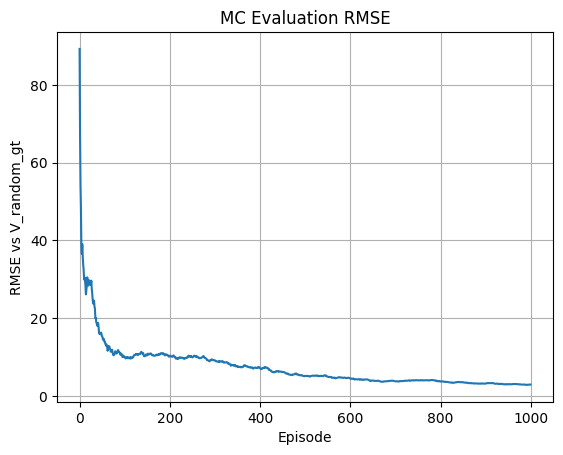

In [2]:
def mc_evaluate(policy, env, episodes=5000, gamma=0.95, seed=None):
    """
    First-visit Monte Carlo (MC) state-value prediction (Sutton & Barto, Alg. 5.1).

    Parameters
    ----------
    policy : ndarray, shape (nS, nA)
        Row-stochastic policy: for each state s, policy[s] is a prob. dist. over actions.
    env : Gymnasium-like environment
        Must expose discrete observation_space.n and action_space.n and return
        (obs, reward, terminated, truncated, info) from step().
    episodes : int
        Number of episodes to sample.
    gamma : float
        Discount factor in [0, 1].
    seed : int | None
        If given, used to seed a NumPy RNG and (re)seed env at each episode start.
    """
    nS, nA = env.observation_space.n, env.action_space.n
    V = np.zeros(nS, dtype=float)          # value estimates
    N_first = np.zeros(nS, dtype=int)      # first-visit counts per state
    visits = np.zeros(nS, dtype=int)       # total visits (diagnostic only)
    errors = []

    rng = np.random.default_rng(seed)

    for ep in tqdm(range(episodes), desc="MC first-visit"):
        # Episode generation under π
        s, _ = env.reset(seed=int(rng.integers(1e9)) if seed is not None else None)
        states, rewards = [], []
        done = False

        while not done:
            a = np.random.choice(nA, p=policy[s])  # sample action from π(·|s)
            states.append(s)
            visits[s] += 1

            s, r, terminated, truncated, _ = env.step(a)
            rewards.append(r)
            done = terminated or truncated

        # Identify first visits of each state in this episode
        first_visit_mask = [False] * len(states)
        seen_from_start = set()
        for t, st in enumerate(states):
            if st not in seen_from_start:
                seen_from_start.add(st)
                first_visit_mask[t] = True

        # Backward return accumulation; update ONLY on first visits
        G = 0.0
        for t in range(len(states) - 1, -1, -1):
            G = gamma * G + rewards[t]
            st = states[t]
            if first_visit_mask[t]:
                # Incremental mean: α_{N(s)} = 1 / N_first[st]
                N_first[st] += 1
                V[st] += (G - V[st]) / N_first[st]
                # (Constant-stepsize alternative)
                # V[st] += 0.01 * (G - V[st])

        # Track RMSE to a reference table for the random policy (from PSET1)
        rmse = float(np.sqrt(np.mean((V - V_random_gt) ** 2)))
        errors.append(rmse)

    return V, errors


# Uniform-random policy for evaluation
policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n

V, errors = mc_evaluate(policy, env, episodes=1000)

print_values(V, 4, 12, "Estimated State Values (MC First-Visit)")
# Compare visually with PSET1 reference; they should be close (up to sampling noise).

plt.figure()
plt.plot(errors)
plt.xlabel("Episode")
plt.ylabel("RMSE vs V_random_gt")
plt.title("MC Evaluation RMSE")
plt.grid(True)
plt.show()

# Note: On my laptop this may take ~1 minute for 1k episodes, depending on Python + Gym versions.

### 1.2 Plot for different step size.

Recall equation (2.4) in the lecture note:
$$
\hat{V}(s) \leftarrow \hat{V}(s) + \alpha_{N(s)}\!\left(g_t - \hat{V}(s)\right),
\qquad \alpha_{N(s)} > 0 \text{ diminishing.}
$$

For standard Monte-Carlo evaluation, you will take the $\alpha_{N(s)}$ as $\frac{1}{N(s)}$. But you have more options: you can do constant step or other steps you prefer.

**TODO: test different step options, and you can also change first-visit to every-visit. What do you observe?**

Hint: you can try save different loss curves and plot in the same plot

### 1.3 Monte-Carlo control with Exploring Starts

In the class we talk about two methods to ensure exploration: exploring starts and $\epsilon$-greedy policy. We will start with exploring starts for monte-carlo control.

**TODO: finish code of Monte-Carlo control with exploring starts**.

In [3]:
def _set_state(env, s):
    """Attempt to set the environment's internal discrete state to `s`
    (needed for Exploring Starts).
    """
    try:
        # Many classic-control/grid envs expose `unwrapped.s`
        env.unwrapped.s = s
        return True
    except Exception:
        # Some variants use `.state` instead
        try:
            env.unwrapped.state = s
            return True
        except Exception:
            return False


def mc_control_exploring_starts(env, episodes=5000, gamma=0.95, max_steps=500, alpha=None):
    """
    Monte Carlo control with Exploring Starts (ES).  See Sutton & Barto, Alg. 5.3.

    Procedure
    ---------
    1) For each episode, sample an initial state–action pair (S0, A0) at random so that
       every (s, a) has nonzero probability.
    2) Roll out the *entire* episode under the current policy π (use A0 at t=0; thereafter
       sample actions from π).
    3) At the end of the episode, perform **first-visit** MC updates to Q(s, a) using the
       return G from each first-visited (s, a).
    4) For all states visited in this episode, improve the policy greedily:
       π(s) ← argmax_a Q(s, a) (break ties uniformly).

    Parameters
    ----------
    env : Gymnasium-like env
        Discrete observation/action spaces; `step()` returns
        (obs, reward, terminated, truncated, info).
    episodes : int
        Number of ES episodes to run.
    gamma : float
        Discount factor in [0, 1].
    max_steps : int
        Safety cap on episode length (helps avoid rare infinite loops).
    alpha : float or None
        Step size for Q-updates. If None, use the sample mean (α = 1 / N(s, a));
        otherwise use a constant step size `alpha` (Robbins–Monro).
    """
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=float)
    N_visits = np.zeros((nS, nA), dtype=int)
    V_snaps = []

    # Initialize π arbitrarily: start with a uniform distribution over actions.
    policy = np.ones((nS, nA), dtype=float) / nA

    for ep in tqdm(range(episodes), desc="MC ES (Exploring Starts)"):
        # --- Exploring Start: choose (S0, A0) uniformly at random ---
        # For CliffWalking we avoid terminal/cliff cells by excluding the last row
        # except the start (index 36). `nS - 11` ensures s0 ∈ {0..36}.
        s0 = np.random.randint(nS - 11)
        a0 = np.random.randint(nA)

        # Reset env, then force the start state to s0. If not supported, ES cannot be run strictly.
        s, _ = env.reset()
        if not _set_state(env, s0):
            raise RuntimeError(
                "Environment does not support setting arbitrary start states; "
                "strict Exploring Starts is not possible."
            )

        # --- Generate a full trajectory under current π (A0 at t=0, then follow π) ---
        states, actions, rewards = [], [], []
        s = s0
        a = a0
        done = False

        # Cap length to avoid pathological loops when π does not reach a terminal.
        for _ in range(max_steps):
            states.append(s)
            actions.append(a)

            s, r, terminated, truncated, _ = env.step(a)
            rewards.append(r)
            done = terminated or truncated
            if done:
                break

            # sample actions from the current policy π
            a = np.random.choice(nA, p=policy[s])

        # --- First-visit masks for (s, a) within this episode ---
        first_visit_sa_mask = [False] * len(states)
        seen_from_start_sa = set()
        for t, (st, at) in enumerate(zip(states, actions)):
            if (st, at) not in seen_from_start_sa:
                seen_from_start_sa.add((st, at))
                first_visit_sa_mask[t] = True

        # --- Backward return accumulation; update Q only at first visits ---
        G = 0.0
        visited_states = set(states)
        for t in range(len(states) - 1, -1, -1):
            G = gamma * G + rewards[t]
            if first_visit_sa_mask[t]:
                st, at = states[t], actions[t]
                N_visits[st, at] += 1
                step = (1.0 / N_visits[st, at]) if alpha is None else alpha
                Q[st, at] += step * (G - Q[st, at])

        # --- Greedy policy improvement on states encountered this episode (uniform tie-breaking) ---
        for st in visited_states:
            best = Q[st].max()
            best_actions = np.flatnonzero(Q[st] == best)
            policy[st] = 0.0
            policy[st, best_actions] = 1.0 / len(best_actions)

        # Keep a few early snapshots of V(s) for quick diagnostics
        if (ep % 100) == 0 and ep <= 10000:
            V = Q.max(axis=1)
            V_snaps.append(V.copy())

    return policy, Q, V_snaps


policy_es, Q_es, V_snaps = mc_control_exploring_starts(env, episodes=200000, gamma=0.95)

V_es = (policy_es * Q_es).sum(axis=1)
print_values(V_es, 4, 12, "V from MC-ES policy")
print_policy(policy_es, 4, 12, "MC-ES derived policy")

# Note: With 200k episodes this can take around a minute on a typical laptop
# (depends on Python/Gym versions and hardware).


MC ES (Exploring Starts): 100%|██████████| 200000/200000 [00:40<00:00, 4947.88it/s]

V from MC-ES policy
-10.91  -9.80  -9.23  -8.64  -8.03  -7.42  -6.74  -6.05  -5.30  -4.53  -3.72  -2.98
 -9.84  -9.35  -8.77  -8.17  -7.53  -6.83  -6.18  -5.45  -4.53  -3.71  -2.85  -1.96
 -9.23  -8.66  -8.08  -7.50  -6.84  -6.15  -5.40  -4.63  -3.71  -2.85  -1.95  -1.00
-10.06   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

MC-ES derived policy
> > > > > > > > v v v v
> > > v v v v v > > v v
> > > > > > > > > > > v
^ T T T T T T T T T T T



### 1.4 Convergence behavior

Use the `V_snap` you get from Monte-Carlo control to plot the convergence evolution.

**TODO: what do you observe form the plot?**

Hint: which part converge first?

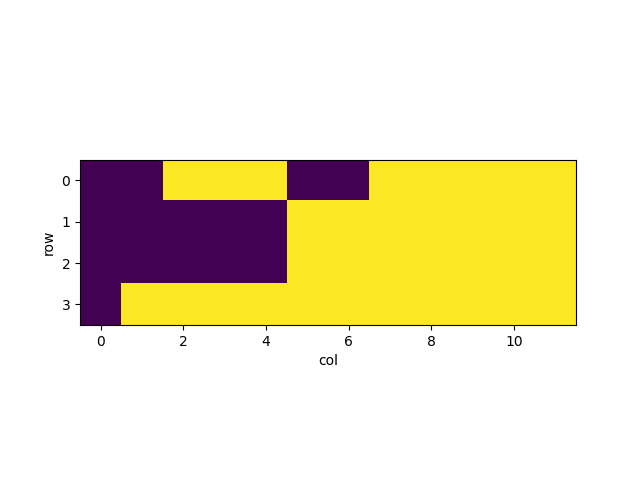

Saved GIF to: ./mc_es_grid_evolution.gif


In [4]:
import matplotlib.animation as animation
from IPython.display import Image, display

# Basic check
V_snaps = [np.asarray(v).ravel() for v in V_snaps]
K = int(V_snaps[0].size)
if K != 48:
    raise ValueError(f"Expected V.size == 48 to reshape into 4x12, but got {K}.")

# Fixed color scale to avoid per-frame jumps (do not specify a colormap; use defaults)
V_all = np.vstack(V_snaps)
vmin, vmax = -20, 0

# Initialize figure: 2D grid
fig, ax = plt.subplots()
grid0 = V_snaps[0].reshape(4, 12)
im = ax.imshow(grid0, vmin=vmin, vmax=vmax)  # Do not specify cmap
ax.set_xlabel("col")
ax.set_ylabel("row")

def init():
    im.set_data(grid0)
    return (im,)  # blit requires a tuple

def update(i):
    grid = V_snaps[i].reshape(4, 12)
    im.set_data(grid)
    return (im,)

ani = animation.FuncAnimation(
    fig, update, frames=len(V_snaps), init_func=init, blit=True, interval=400, repeat=False
)

gif_path = "./mc_es_grid_evolution.gif"
ani.save(gif_path, writer="pillow")
plt.close(fig)

display(Image(filename=gif_path))
print("Saved GIF to:", gif_path)

# Print the last frame as a 4x12 grid
V_last = V_snaps[-1].reshape(4, 12)
np.set_printoptions(precision=2, suppress=True)  # Pretty printing

### 1.5 Random walk on a ring: Why can monte-carlo method works? (Pen and Paper)

In this problem you will use a random walk problem to analyze the convergence behavior of Monte-Carlo control.

Consider a 1-D random walk problem on a ring, and one of them is the terminal state. Assume states are $\{0,1,2,...,K - 1\}$, and $0$ is the terminal state. The transition model can be written as $x_{k+1} = \text{mod}(x_k + u_k)$ where $u_k = -1 / 1$.

**Setup.**  
States $ \mathcal S=\{0,1,\dots,K-1\} $ with terminal $0$ (absorbing).  
Actions $ \mathcal A=\{-1,+1\} $, transition $ s'=(s+a)\bmod K $ (Note that terminal is absorb, so once it arrive $0$ it will not move).  
Per-step reward $-1$ until termination; discount $ \gamma\in(0,1] $.  
Distance to $0$: $ d(s)=\min\{s,K-s\} $.  
Algorithm: first-visit Monte-Carlo control with **Exploring Starts**.

**Claim.** With probability $1$, the learned policy converges to
$$
\pi^\star(s)=
\begin{cases}
\text{move to reduce } d(s), & d(s)\neq K/2,\\
\text{either action}, & d(s)=K/2 \text{ (if $K$ even),}
\end{cases}
$$
i.e., “go along the shortest arc to $0$”.

### Proof (outward induction on $d$)

First we write down the optimal value $V^\star$ under $\pi^\star$

**(a) TODO: write down $V^\star$** 

**Answer:**

$$
V^\star(s)=
\begin{cases}
-d(s), & \gamma=1,\\[2pt]
-\displaystyle \sum_{i=0}^{d(s)-1}\gamma^i \;=\; -\frac{1-\gamma^{d(s)}}{1-\gamma}, & 0<\gamma<1.
\end{cases}
$$

**Base of induction ($d=0$).** 

**(b) TODO: Show that $Q(0,a)\equiv 0$** 

**Answer:** State $0$ is terminal, so all returns are $0$; hence $Q(0,a)\equiv 0$.

**Inductive hypothesis.** For every state with $d\le m-1$, the maximization of $Q(s,a)$ is already optimal, i.e.
$$
\max_a Q(s,a) := V(s) = V^\star
$$

**(b) TODO: For $d(s)=m$, show that $Q(s,\text{toward}) \leq Q(s,\text{away})$ (equality hold only when $s = \frac{K}{2}$)** 

**Answer:** 

compare two actions:
- **Toward $0$** (to distance $m-1$):
  $$
  q^{\pi}(s,\text{toward})=-1+\gamma\,V^\star(m-1).
  $$
- **Away from $0$** (to distance $m+1$):
  $$
  q^{\pi}(s,\text{away})\le -1+\gamma\,V^\star(m+1).
  $$

Thus
$$
q^{\pi}(s,\text{toward})-q^{\pi}(s,\text{away})
\;\ge\;\gamma\big(V^\star(m-1)-V^\star(m+1)\big).
$$

For $\gamma=1$, $V^\star(d)=-d$, so the RHS equals $2>0$.  
For $0<\gamma<1$, $V^\star(d)=-(1-\gamma^d)/(1-\gamma)=-\sum_{i=0}^{d-1}\gamma^i$, hence
$$
V^\star(m-1)-V^\star(m+1)=\gamma^{m-1}(1+\gamma)
\;\Rightarrow\;
q^{\pi}(s,\text{toward})-q^{\pi}(s,\text{away})\ge \gamma^{m}(1+\gamma)>0.
$$
Therefore greedy improvement sets $\pi(s)=\text{toward}$. By convergence of monte-carlo evaluation under fix policy, $Q(s,\text{toward})$ finally converge.

### 1.6 Monte-Carlo control with $\epsilon$-soft policies

**TODO: finish the code for Monte-Carlo control with $\epsilon$-soft policies** 

In [5]:
def _epsilon_soft_from_Q(Q_row: np.ndarray, epsilon: float, tol: float = 1e-12) -> np.ndarray:
    """
    Build an ε-soft *greedy* action distribution from a vector of Q-values.

    Rule:
      1) Give every action a base mass ε/|A|.
      2) Split the remaining (1-ε) uniformly among the greedy (argmax) actions.
         (Deterministic tie-handling: no random tie-breaking.)

    Args
    ----
    Q_row : (nA,) array
        Action values for a single state.
    epsilon : float in [0, 1]
        Exploration parameter.
    """
    nA = Q_row.shape[0]
    probs = np.full(nA, epsilon / nA, dtype=float)

    m = Q_row.max()
    ties = np.flatnonzero(np.isclose(Q_row, m, atol=tol, rtol=0.0))
    share = (1.0 - epsilon) / ties.size
    probs[ties] += share
    return probs


def mc_control_onpolicy_epsilon_soft(
    env,
    episodes: int = 5000,
    gamma: float = 0.95,
    max_steps: int = 500,
    alpha: float | None = None,   # None → sample mean 1/N(s,a); else constant step-size
    epsilon: float = 0.1,         # constant ε if no schedule is provided
    eps_schedule=None,            # optional callable: eps = eps_schedule(ep)  (GLIE-style)
    min_epsilon: float = 0.0,
):
    """
    On-policy first-visit Monte Carlo control with ε-soft policies
    (Sutton & Barto, On-policy MC Control).

    Key differences from MC with Exploring Starts (ES):
      • No exploring starts; episodes are generated by the current ε-soft policy π.
      • Policy improvement *keeps* π ε-soft: greedy actions get (1-ε)+ε/|A|, others ε/|A|.
    """
    nS = env.observation_space.n
    nA = env.action_space.n

    Q = np.zeros((nS, nA), dtype=float)
    N_first = np.zeros((nS, nA), dtype=int)

    # Initialize π arbitrarily: uniform over actions (already ε-soft for any ε).
    policy = np.full((nS, nA), 1.0 / nA, dtype=float)

    ep_idx, V_snaps = [], []

    for ep in tqdm(range(episodes), desc="MC (ε-soft)"):
        # GLIE-style ε schedule (optional)
        eps = float(eps_schedule(ep)) if eps_schedule is not None else float(epsilon)
        eps = float(np.clip(eps, min_epsilon, 1.0))

        # ---- Generate one episode under current ε-soft policy π ----
        states, actions, rewards = [], [], []
        s, _ = env.reset()
        a = int(np.random.choice(nA, p=policy[s]))  # first action from current policy

        for _ in range(max_steps):
            states.append(int(s))
            actions.append(int(a))

            s, r, terminated, truncated, _ = env.step(a)
            rewards.append(float(r))
            if terminated or truncated:
                break

            a = int(np.random.choice(nA, p=policy[s]))

        # ---- First-visit markers for (s,a) within this episode ----
        seen = set()
        first_visit = [False] * len(states)
        for t, (st, at) in enumerate(zip(states, actions)):
            if (st, at) not in seen:
                seen.add((st, at))
                first_visit[t] = True

        # ---- Backward return accumulation; update Q only at first visits ----
        G = 0.0
        for t in range(len(states) - 1, -1, -1):
            G = gamma * G + rewards[t]
            if first_visit[t]:
                st, at = states[t], actions[t]
                N_first[st, at] += 1
                step = (1.0 / N_first[st, at]) if alpha is None else alpha
                Q[st, at] += step * (G - Q[st, at])

        # ---- ε-soft greedy policy improvement (only on states seen this episode) ----
        visited_states = set(states)
        for st in visited_states:
            policy[st] = _epsilon_soft_from_Q(Q[st], eps)

        # Light snapshots for convergence plots (every 100 eps)
        if (ep % 100) == 0:
            V = Q.max(axis=1)
            V_snaps.append(V.copy())

    return policy, Q, V_snaps


def eps_schedule(ep, c=2000.0, eps_min=0.01):
    """Simple GLIE schedule: ε_ep = max(eps_min, c / (c + ep))."""
    return max(eps_min, c / (c + ep))


policy, Q, V_snaps = mc_control_onpolicy_epsilon_soft(
    env,
    episodes=10000,
    gamma=0.95,
    epsilon=1.0,  # start fully exploratory; schedule will decay it
    eps_schedule=lambda ep: eps_schedule(ep, c=2000.0, eps_min=0.01),
    min_epsilon=0.0,
    alpha=0.01    # constant step-size for Q-updates (try None for 1/N(s,a))
)

V_soft = (policy * Q).sum(axis=1)
print_values(V_soft, 4, 12, "V from MC ε-soft policy")
print_policy(policy, 4, 12, "MC ε-soft derived policy")


MC (ε-soft): 100%|██████████| 10000/10000 [00:09<00:00, 1110.77it/s]

V from MC ε-soft policy
-12.07 -11.56 -10.96 -10.33  -9.74  -9.01  -8.36  -7.50  -6.69  -5.72  -4.78  -4.19
-12.50 -13.53 -13.78 -14.11 -13.74 -13.52 -12.22 -11.21 -10.35  -8.79  -4.31  -2.55
-13.31 -20.43 -28.10 -38.71 -39.91 -42.90 -42.03 -38.27 -36.27 -25.17 -10.28  -1.51
-19.09   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

MC ε-soft derived policy
> > > > > > > > > > v v
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ > v
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ > v
^ T T T T T T T T T T T



## Problem 2: SARSA & Q-learning on Cliffwalk environment

### 2.1 TD evaluation

**Algorithmic Form.** Suppose the agent is in state $s_t$, takes action $a_t \sim \pi(\cdot \mid s_t)$, receives reward $r_t$, and transitions to $s_{t+1}$. The TD(0) update rule is
$$
\hat V(s_t) \leftarrow \hat V(s_t) + \alpha\,[\,r_t + \gamma \hat V(s_{t+1}) - \hat V(s_t)\,],
\tag{2.6}
$$
where $\alpha \in (0,1]$ is the learning rate.

The term inside the brackets,
$$
\delta_t = r_t + \gamma \hat V(s_{t+1}) - \hat V(s_t),
\tag{2.7}
$$
is called the **TD error**.

**TODO: finish the code for TD evluation**

TD evaluation: 100%|██████████| 1000/1000 [01:06<00:00, 15.09it/s]

Estimated State Values (TD(0) evaluation)
-140.91 -146.25 -149.89 -155.39 -155.01 -153.61 -152.08 -148.13 -144.75 -134.43 -121.71 -104.83
-160.81 -174.23 -179.88 -181.70 -188.86 -182.66 -183.50 -181.28 -173.97 -166.05 -144.95 -107.81
-201.01 -239.41 -241.61 -247.49 -255.39 -257.13 -244.55 -238.85 -243.54 -223.35 -189.40 -88.30
-247.89   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



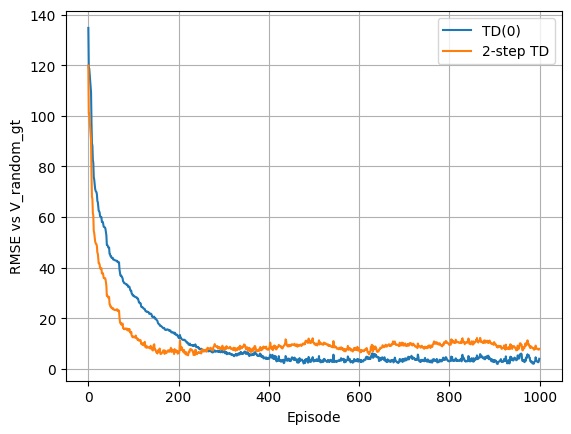

In [6]:
def td0_evaluate(env, episodes=5000, gamma=0.95, alpha=0.1, seed=None):
    """
    On-policy temporal-difference evaluation under a **uniform random policy**.

    Computes:
      • V_TD0 : TD(0) / 1-step bootstrap   V(s_t) ← V(s_t) + α [ r_t + γ V(s_{t+1}) − V(s_t) ]
      • V_TD2 : 2-step TD for the *previous* state s_{t-1}
                V(s_{t-1}) ← V(s_{t-1}) + α [ r_{t-1} + γ r_t + γ^2 V(s_{t+1}) − V(s_{t-1}) ]
                (This is the n=2 special case of n-step TD.)
    Returns V_TD0 and RMSE traces for both estimators vs the provided V_random_gt.
    """
    nS, nA = env.observation_space.n, env.action_space.n
    policy = np.ones((nS, nA)) / nA

    V_TD0 = np.zeros(nS, dtype=float)
    V_TD2 = np.zeros(nS, dtype=float)

    visit_counts = np.zeros(nS, dtype=int)  # diagnostic only
    errors_1, errors_2 = [], []

    if seed is not None:
        np.random.seed(seed)

    for _ in tqdm(range(episodes), desc="TD evaluation"):
        s, _ = env.reset()
        done = False

        # Keep the previous transition to form a 2-step target
        prev_state = None      # will hold s_{t-1}
        prev_reward = None     # will hold r_{t-1}

        while not done:
            # Act according to the (fixed) random policy
            a = np.random.choice(nA, p=policy[s])

            # Environment step: obtain r_t and s_{t+1}
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            # ----- TD(0) update for current state s_t -----
            td_error_1 = r + gamma * V_TD0[s_next] - V_TD0[s]
            V_TD0[s] += alpha * td_error_1
            visit_counts[s] += 1

            # ----- 2-step TD update for the previous state s_{t-1} -----
            # Target: r_{t-1} + γ r_t + γ^2 V(s_{t+1})
            if prev_state is not None:
                target_2 = prev_reward + gamma * r + (gamma ** 2) * V_TD2[s_next]
                td_error_2 = target_2 - V_TD2[prev_state]
                V_TD2[prev_state] += alpha * td_error_2

            # Shift the window: current transition becomes "previous" for next step
            prev_state = s
            prev_reward = r
            s = s_next

        # Episode-level RMSE diagnostics
        errors_1.append(np.sqrt(np.mean((V_TD0 - V_random_gt) ** 2)))
        errors_2.append(np.sqrt(np.mean((V_TD2 - V_random_gt) ** 2)))

    return V_TD0, (errors_1, errors_2)


# Example run
V, (errors_1, errors_2) = td0_evaluate(env, episodes=1000, alpha=0.01)

print_values(V, 4, 12, "Estimated State Values (TD(0) evaluation)")

plt.figure()
plt.plot(errors_1, label="TD(0)")
plt.plot(errors_2, label="2-step TD")
plt.xlabel("Episode")
plt.ylabel("RMSE vs V_random_gt")
plt.grid(True)
plt.legend()
plt.show()

# Note: On my laptop this may take ~20s for 1k episodes


### 2.2 SARSA algorithm

In [7]:
def sarsa(
    env,
    episodes=5000,
    Q_init=None,
    gamma=0.95,
    epsilon=0.01,
    alpha=0.1,
    max_steps=500,       # per-episode safety cap
):
    """
    On-policy SARSA(0) control for **tabular, discrete** Gymnasium environments.

    Behavior policy: ε-greedy w.r.t. current Q.
    Update rule (per step):
        Q(s,a) ← Q(s,a) + α [ r + γ Q(s', a') − Q(s,a) ],
    where a' is sampled ε-greedily from state s' (on-policy).
    """
    nS, nA = env.observation_space.n, env.action_space.n
    Q = Q_init.copy() if Q_init is not None else np.zeros((nS, nA), dtype=float)
    visits = np.zeros((nS, nA), dtype=int)
    V_snaps = []

    def eps_greedy_action(s, eps):
        """ε-greedy over Q[s]: uniform random with prob ε; otherwise greedy with random tie-break."""
        if np.random.rand() < eps:
            return np.random.randint(nA)
        row = Q[s]
        m = row.max()
        candidates = np.flatnonzero(row == m)
        return int(np.random.choice(candidates))

    for ep in tqdm(range(episodes), desc="SARSA control"):
        s, _ = env.reset()
        a = eps_greedy_action(s, epsilon)

        # (Optional) record of visited states; useful for debugging/plots.
        s_record = []

        for _ in range(max_steps):
            # Environment transition using the *current* action a
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            s_record.append(s)

            # On-policy next action a' (only if not terminal)
            if not done:
                a_next = eps_greedy_action(s_next, epsilon)
                target = r + gamma * Q[s_next, a_next]
            else:
                a_next = None
                target = r

            # SARSA(0) TD update
            td_error = target - Q[s, a]
            Q[s, a] += alpha * td_error
            visits[s, a] += 1

            if done:
                break

            # Roll to next transition
            s, a = s_next, a_next

        # Lightweight snapshots early on (every 2 episodes up to 100)
        if (ep % 2) == 0 and ep <= 100:
            V_snaps.append(Q.max(axis=1).copy())

    return Q, visits, V_snaps


Q, visits, V_snaps = sarsa(env, episodes=50000, gamma=0.95, alpha=0.01, epsilon=0.01)
V = Q.max(axis=1)
print_values(V, 4, 12, title="State Values (greedy after SARSA)")


SARSA control: 100%|██████████| 50000/50000 [00:08<00:00, 5765.95it/s]

State Values (greedy after SARSA)
 -9.48  -9.13  -8.69  -8.20  -7.67  -7.10  -6.50  -5.85  -5.17  -4.45  -3.68  -2.86
 -9.76  -9.22  -8.65  -8.05  -7.42  -6.76  -6.06  -5.32  -4.56  -3.73  -2.87  -1.96
-10.27  -9.75  -8.98  -7.92  -7.09  -6.36  -5.63  -4.77  -3.77  -2.87  -1.95  -1.00
-10.76   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



### 2.3 Q-learning algorithm

In [8]:
def q_learning(
    env,
    episodes=20000,
    gamma=0.95,
    epsilon=0.01,
    alpha=0.1,
    max_steps=500,       # per-episode safety cap
):
    """
    Tabular **Q-learning** (off-policy, 1-step TD) control.

    Behavior policy: ε-greedy w.r.t. current Q (for exploration).
    Target policy:   greedy (max over actions in s')  — this is what makes it **off-policy**.

    Update (per step):
        Q(s,a) ← Q(s,a) + α [ r + γ * max_{a'} Q(s', a') − Q(s,a) ].
    """
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=float)
    visits = np.zeros((nS, nA), dtype=int)  # diagnostic: how often each (s,a) is updated
    V_snaps = []

    def eps_greedy_action(s, eps):
        """ε-greedy over Q[s]: with prob ε pick random action; else greedy with random tie-break."""
        if np.random.rand() < eps:
            return np.random.randint(nA)
        row = Q[s]
        m = row.max()
        candidates = np.flatnonzero(row == m)  # random tie-breaking argmax
        return int(np.random.choice(candidates))

    for ep in tqdm(range(episodes), desc="Q-learning control"):
        s, _ = env.reset()

        for _ in range(max_steps):
            # --- behavior action (ε-greedy) ---
            a = eps_greedy_action(s, epsilon)

            # --- environment transition ---
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            # --- off-policy target: greedy bootstrap in s' ---
            target = r if done else r + gamma * Q[s_next].max()

            # --- Q-learning update ---
            td = target - Q[s, a]
            Q[s, a] += alpha * td
            visits[s, a] += 1

            if done:
                break
            s = s_next

        # light snapshots early on (every 10 episodes up to 1k)
        if (ep % 10) == 0 and ep <= 1000:
            V_snaps.append(Q.max(axis=1).copy())

    return Q, V_snaps


Q, V_snaps = q_learning(env, episodes=50000, gamma=0.95, alpha=0.01, epsilon=0.01)
V = Q.max(axis=1)
print_values(V, 4, 12, title="State Values (greedy after Q-learning)")


Q-learning control: 100%|██████████| 50000/50000 [00:10<00:00, 4795.61it/s]

State Values (greedy after Q-learning)
 -8.70  -8.42  -8.04  -7.59  -7.10  -6.56  -6.00  -5.39  -4.76  -4.10  -3.43  -2.76
 -8.97  -8.61  -8.16  -7.67  -7.13  -6.54  -5.90  -5.22  -4.48  -3.69  -2.85  -1.95
 -9.19  -8.62  -8.03  -7.40  -6.73  -6.03  -5.30  -4.52  -3.71  -2.85  -1.95  -1.00
 -9.73   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

